In [1]:
# general packages
import numpy as np
import os
import sys
import inspect

# H-FISTA packages
currentdir = %pwd 
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from lib import Residual
from fista import fista
from helpers import get_data
from lambda_loop import take_lambda_step, initialize_io_dict, get_initial_lambda
from stopping import check_stopping

# plotting tools
import matplotlib.pyplot as plt
from plotting import make_plots, get_diag_plot, get_paper_figure, get_dynamic_field_plot
from scipy.fft import fftshift

%matplotlib inline

# plot style adjustement, remove if jupyter themes not avaiable
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, ticks=True, grid=False,)

# further plot configuration
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.aspect"] = "auto"
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams["axes.linewidth"] = 3

### Load and plot data

2022-10-27 09:44:31,451 - H-FISTA.helpers - WARNING - Loading data/simulated/simulated_25percent_noisefree.fits as a psrflux ASCII file failed. Trying to load as a FITS file.


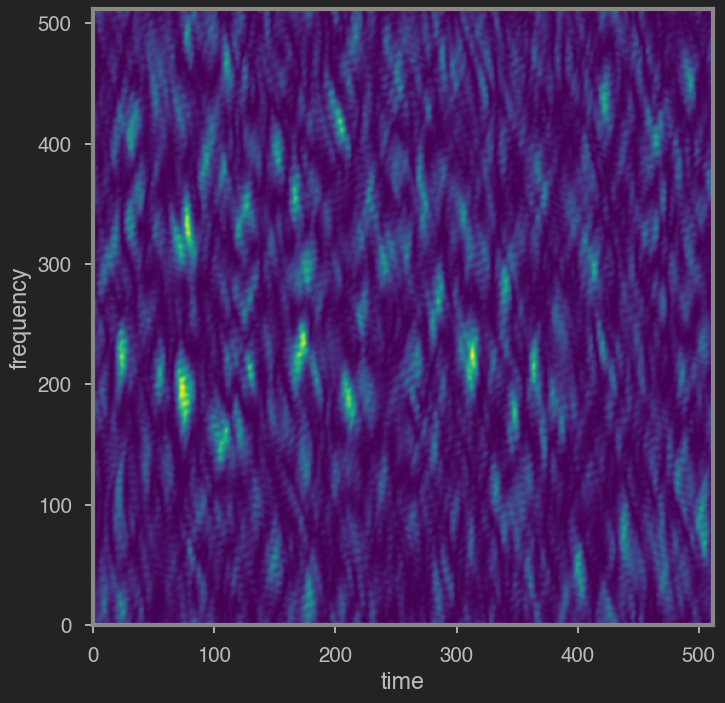

In [2]:
data = get_data("data/simulated/simulated_25percent_noisefree.fits").T

plt.imshow(data.T)
_ = plt.xlabel("time")
_ = plt.ylabel("frequency")

## H-FISTA
### Generate initial values

In [3]:
# initial RFI mask does not mask any data
mask = np.ones_like(data)

# initial guess with all power in one wave at the origin
N, M = data.shape
h_init = np.zeros((N, M)) + np.zeros((N, M)) * 1.0j

init_value = np.sqrt(np.mean(data * mask)) * N * M + 0.0j
init_coords = [0, 0]
h_init[init_coords[0], init_coords[1]] = init_value

# H-FISTA configuration
lambda_scale = 1.15
desired_components = 60
fix_phase_value = 0.0
fix_phase_coords = init_coords

# FISTA configuration
FISTA_niter = 80
delay_for_inf = -4
backtrack = True
verbose = False

### Initialise I/O dictionary

In [4]:
# pre-populate the rest of the input output dictionary
io = initialize_io_dict()

# setup the initial guess as a step so that we can use the exact same loop for all runs below
step = 0

io["niters"][step] = 0 

# mask = np.ones_like(data) # in this particular case, we already have a mask
io["masks"][step] = mask
resid = Residual(data, h_init, None, mask)
io["lambdas"][step] = get_initial_lambda(desired_components, delay_for_inf, resid) * lambda_scale
io["models"][step] = h_init
io["demerits"][step] = -1
io["predictions"][step] = resid.prediction
io["residuals"][step] = resid.residual

In [5]:
chosen_step = -1

approved = np.transpose(np.nonzero(h_init))

# in this case, the stopping criteria will never trigger so we manually shorten the number of iterations
# we know the number of iterations necessary from a previous run
for step in range(1, 67):
    io["niters"][step] = FISTA_niter
    ref_lambda = io["lambdas"][step-1]/lambda_scale

    lambda_loop_config = {
        "backtrack": backtrack,
        "fix_phase_value": fix_phase_value,
        "fix_phase_coords": init_coords,
        "ref_lambda": ref_lambda, 
        "verbose": verbose,
        "delay_for_inf": delay_for_inf,
        "zero_penalty_coords": approved,
        "clean_RFI": False, # RFI cleaning can get overly eager in noise free cases
    }

    print()
    print(f"### λ iteration {step} with λ={ref_lambda} and scaling {lambda_scale} ###")
    print() 

    approved = take_lambda_step(data, io, step, **lambda_loop_config)
    io["lambdas"][step] = ref_lambda
    
    if step > 1:
        if check_stopping(io, step):
            chosen_step = step - 1
            print(f"Stopping criterion triggered in step {step}")
            break


### λ iteration 1 with λ=3.3574390822645267e-07 and scaling 1.15 ###

2022-10-27 09:44:32,101 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 1 components (approved: 1 and fixed support 0)
2022-10-27 09:44:32,627 - H-FISTA.fista - INFO - backtrack_B3 found 5.4e-09 after 4 iterations. Model has 61 el.
2022-10-27 09:44:32,652 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 61 non-zero elements with demerit 0.0139
2022-10-27 09:44:34,822 - H-FISTA.fista - INFO - backtrack_B3 found 5.94e-09 after 1 iterations. Model has 85 el.
2022-10-27 09:44:38,859 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 76 non-zero elements with demerit 0.0122
2022-10-27 09:44:40,054 - H-FISTA.fista - INFO - backtrack_B3 found 6.53e-09 after 1 iterations. Model has 76 el.
2022-10-27 09:44:42,606 - H-FISTA.fista - INFO - Arrived at model with 75 components/ 0.0122 after 80 iterations
2022-10-27 09:44:42,630 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 75 components (

2022-10-27 09:45:56,038 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 135 non-zero elements with demerit 0.00562
2022-10-27 09:45:56,397 - H-FISTA.fista - INFO - backtrack_B3 found 4.05e-09 after 1 iterations. Model has 135 el.
2022-10-27 09:45:57,112 - H-FISTA.fista - INFO - backtrack_B3 found 8.69e-09 after 8 iterations. Model has 135 el.
2022-10-27 09:46:01,634 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 135 non-zero elements with demerit 0.00536
2022-10-27 09:46:04,479 - H-FISTA.fista - INFO - Arrived at model with 135 components/ 0.00536 after 80 iterations
2022-10-27 09:46:04,483 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 22.091389221821544
2022-10-27 09:46:04,485 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 6 with λ=1.6692406018831641e-07 and scaling 1.15 ###

2022-10-27 09:46:04,508 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 135 components (approved:

2022-10-27 09:47:18,323 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 13.893905835958968
2022-10-27 09:47:18,324 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 10 with λ=9.543937318023675e-08 and scaling 1.15 ###

2022-10-27 09:47:18,354 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 273 components (approved: 273 and fixed support 0)
2022-10-27 09:47:18,573 - H-FISTA.fista - INFO - backtrack_B3 found 4.46e-09 after 2 iterations. Model has 343 el.
2022-10-27 09:47:18,593 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 343 non-zero elements with demerit 0.00312
2022-10-27 09:47:19,006 - H-FISTA.fista - INFO - backtrack_B3 found 4.9e-09 after 1 iterations. Model has 337 el.
2022-10-27 09:47:19,619 - H-FISTA.fista - INFO - backtrack_B3 found 9.56e-09 after 7 iterations. Model has 337 el.
2022-10-27 09:47:23,742 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 334 non-zero eleme

2022-10-27 09:48:25,010 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 628 non-zero elements with demerit 0.00172
2022-10-27 09:48:25,477 - H-FISTA.fista - INFO - backtrack_B3 found 5.4e-09 after 3 iterations. Model has 626 el.
2022-10-27 09:48:25,972 - H-FISTA.fista - INFO - backtrack_B3 found 9.56e-09 after 6 iterations. Model has 624 el.
2022-10-27 09:48:29,940 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 620 non-zero elements with demerit 0.0017
2022-10-27 09:48:32,510 - H-FISTA.fista - INFO - Arrived at model with 620 components/ 0.0017 after 80 iterations
2022-10-27 09:48:32,527 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 620 components (approved: 0 and fixed support 620)
2022-10-27 09:48:32,528 - H-FISTA.fista - INFO - Fixing support
2022-10-27 09:48:32,670 - H-FISTA.fista - INFO - backtrack_B3 found 4.05e-09 after 1 iterations. Model has 620 el.
2022-10-27 09:48:32,687 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 620 non-zero elements with

2022-10-27 09:49:31,620 - H-FISTA.fista - INFO - backtrack_B3 found 4.05e-09 after 1 iterations. Model has 1184 el.
2022-10-27 09:49:31,637 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 1184 non-zero elements with demerit 0.00096
2022-10-27 09:49:32,048 - H-FISTA.fista - INFO - backtrack_B3 found 5.94e-09 after 4 iterations. Model has 1178 el.
2022-10-27 09:49:32,581 - H-FISTA.fista - INFO - backtrack_B3 found 1.16e-08 after 7 iterations. Model has 1178 el.
2022-10-27 09:49:36,426 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 1164 non-zero elements with demerit 0.000943
2022-10-27 09:49:38,822 - H-FISTA.fista - INFO - Arrived at model with 1164 components/ 0.000943 after 80 iterations
2022-10-27 09:49:38,836 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 1164 components (approved: 0 and fixed support 1164)
2022-10-27 09:49:38,837 - H-FISTA.fista - INFO - Fixing support
2022-10-27 09:49:38,980 - H-FISTA.fista - INFO - backtrack_B3 found 4.05e-09 after 1 ite

2022-10-27 09:50:30,745 - H-FISTA.fista - INFO - backtrack_B3 found 7.9e-09 after 7 iterations. Model has 1765 el.
2022-10-27 09:50:30,959 - H-FISTA.fista - INFO - backtrack_B3 found 9.56e-09 after 2 iterations. Model has 1765 el.
2022-10-27 09:50:31,266 - H-FISTA.fista - INFO - backtrack_B3 found 1.05e-08 after 1 iterations. Model has 1765 el.
2022-10-27 09:50:34,886 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 1765 non-zero elements with demerit 0.00049
2022-10-27 09:50:37,329 - H-FISTA.fista - INFO - Arrived at model with 1765 components/ 0.00049 after 80 iterations
2022-10-27 09:50:37,336 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 1.9510671260413055
2022-10-27 09:50:37,338 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 22 with λ=1.7838301256719775e-08 and scaling 1.15 ###

2022-10-27 09:50:37,363 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 1765 components (approv

2022-10-27 09:51:31,068 - H-FISTA.fista - INFO - backtrack_B3 found 8.69e-09 after 8 iterations. Model has 3099 el.
2022-10-27 09:51:31,470 - H-FISTA.fista - INFO - backtrack_B3 found 1.05e-08 after 2 iterations. Model has 3088 el.
2022-10-27 09:51:31,787 - H-FISTA.fista - INFO - backtrack_B3 found 1.16e-08 after 1 iterations. Model has 3077 el.
2022-10-27 09:51:35,235 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 3071 non-zero elements with demerit 0.000279
2022-10-27 09:51:37,620 - H-FISTA.fista - INFO - Arrived at model with 3069 components/ 0.000279 after 80 iterations
2022-10-27 09:51:37,637 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 3069 components (approved: 0 and fixed support 3069)
2022-10-27 09:51:37,637 - H-FISTA.fista - INFO - Fixing support
2022-10-27 09:51:37,772 - H-FISTA.fista - INFO - backtrack_B3 found 4.05e-09 after 1 iterations. Model has 3069 el.
2022-10-27 09:51:37,788 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 3069 non-zero el

2022-10-27 09:52:36,422 - H-FISTA.fista - INFO - backtrack_B3 found 4.05e-09 after 1 iterations. Model has 4979 el.
2022-10-27 09:52:36,449 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 4979 non-zero elements with demerit 0.000133
2022-10-27 09:52:36,904 - H-FISTA.fista - INFO - backtrack_B3 found 4.9e-09 after 2 iterations. Model has 4971 el.
2022-10-27 09:52:37,813 - H-FISTA.fista - INFO - backtrack_B3 found 1.54e-08 after 12 iterations. Model has 4961 el.
2022-10-27 09:52:41,972 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 4940 non-zero elements with demerit 0.00013
2022-10-27 09:52:44,518 - H-FISTA.fista - INFO - Arrived at model with 4940 components/ 0.00013 after 80 iterations
2022-10-27 09:52:44,534 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 4940 components (approved: 0 and fixed support 4940)
2022-10-27 09:52:44,535 - H-FISTA.fista - INFO - Fixing support
2022-10-27 09:52:44,686 - H-FISTA.fista - INFO - backtrack_B3 found 4.05e-09 after 1 iter

2022-10-27 09:53:51,107 - H-FISTA.fista - INFO - backtrack_B3 found 4.9e-09 after 2 iterations. Model has 6893 el.
2022-10-27 09:53:52,028 - H-FISTA.fista - INFO - backtrack_B3 found 1.69e-08 after 13 iterations. Model has 6893 el.
2022-10-27 09:53:55,987 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 6893 non-zero elements with demerit 6.12e-05
2022-10-27 09:53:58,354 - H-FISTA.fista - INFO - Arrived at model with 6893 components/ 6.11e-05 after 80 iterations
2022-10-27 09:53:58,373 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.26039494061133384
2022-10-27 09:53:58,375 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 33 with λ=3.834221959874424e-09 and scaling 1.15 ###

2022-10-27 09:53:58,404 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 6893 components (approved: 6893 and fixed support 0)
2022-10-27 09:53:58,540 - H-FISTA.fista - INFO - backtrack_B3 found 4.05e-09 after 

In [6]:
print(f"chosen step: {chosen_step} sparse wavefield components: {np.count_nonzero(io['models'][chosen_step])}")

chosen step: 33 sparse wavefield components: 7583


### Inspect dynamic field progression

#### Plot the magnitude and phase of the dynamic field H

We note that that the magnitude of H is the square root of the dynamic spectrum

We plot the dynamic field for the first three λ iterations, and the chosen step. If no step was chosen, we use the last available step

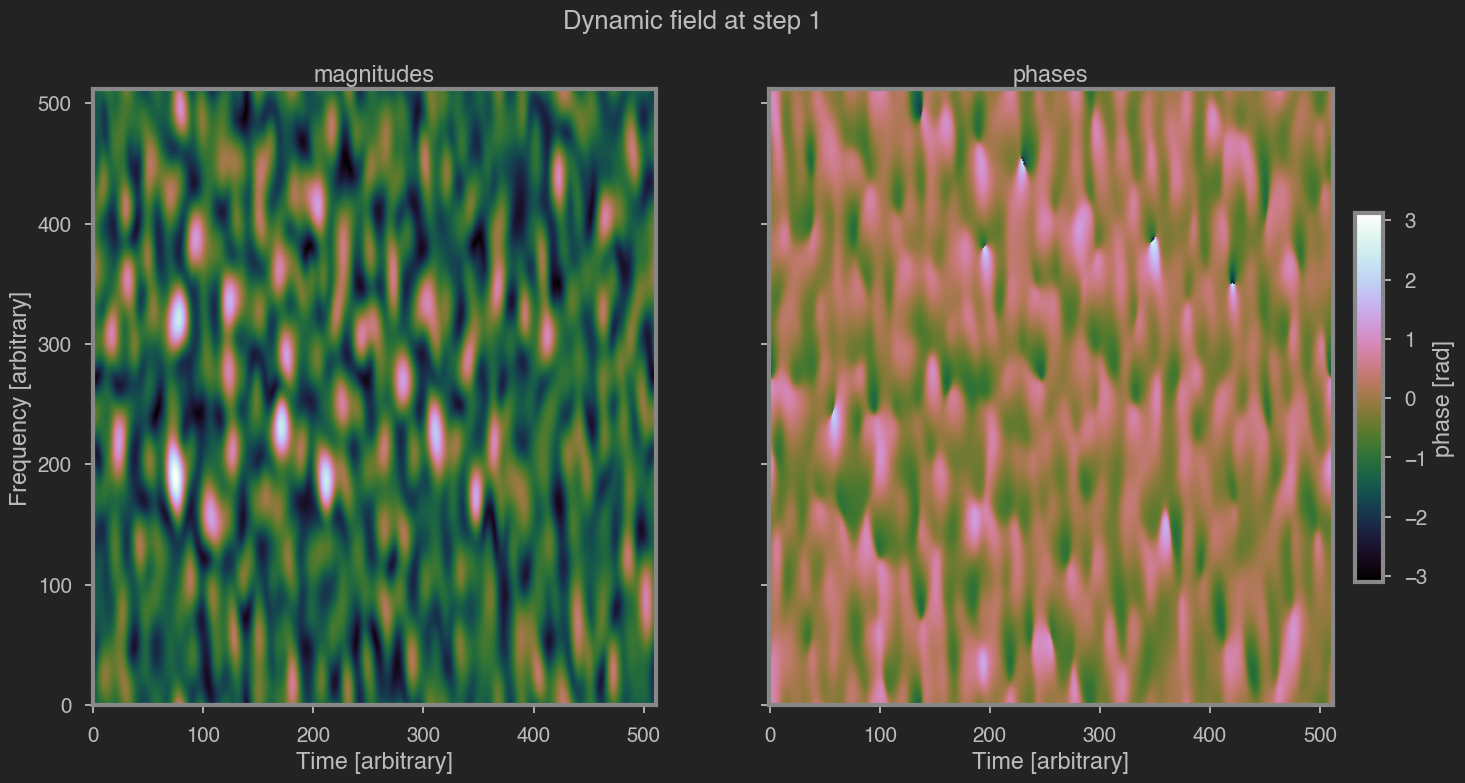

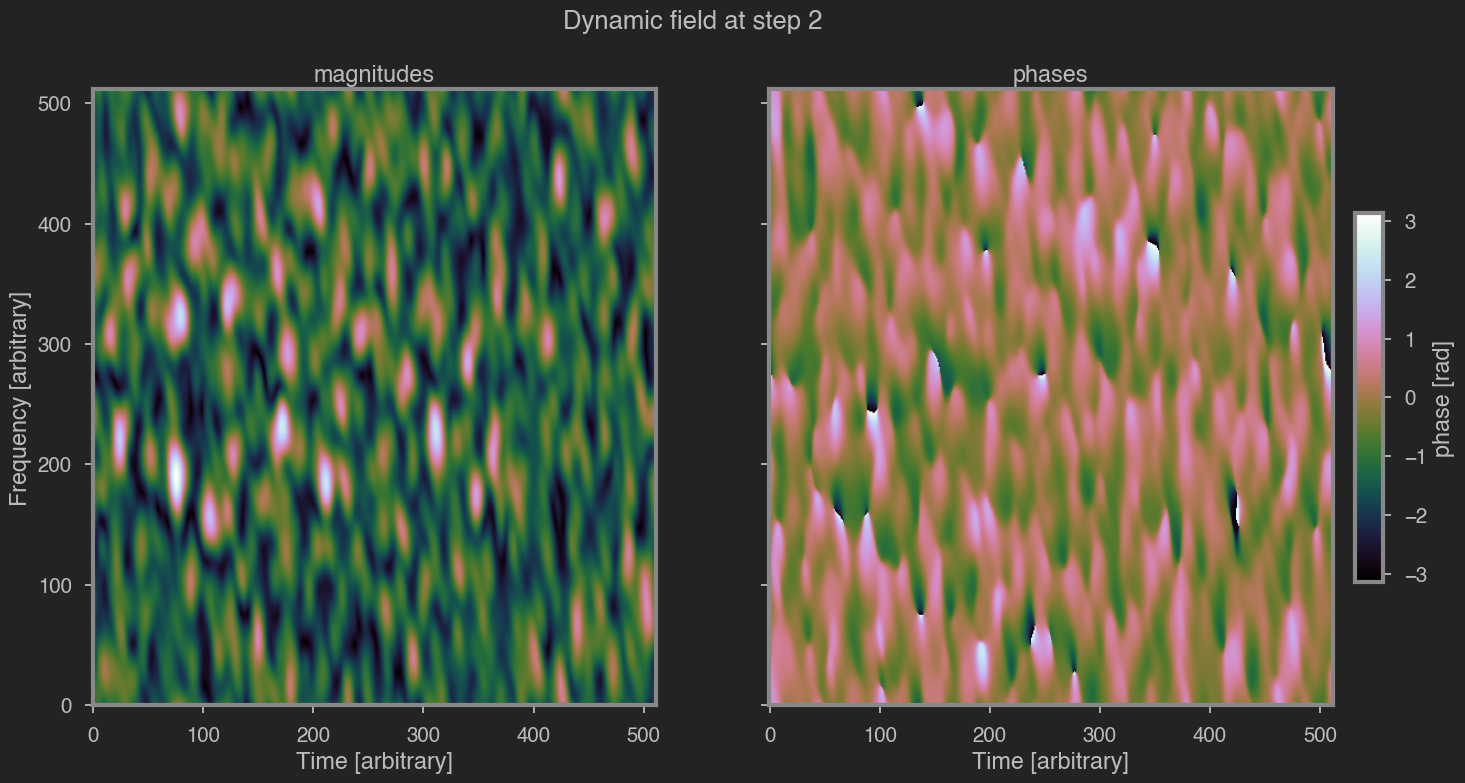

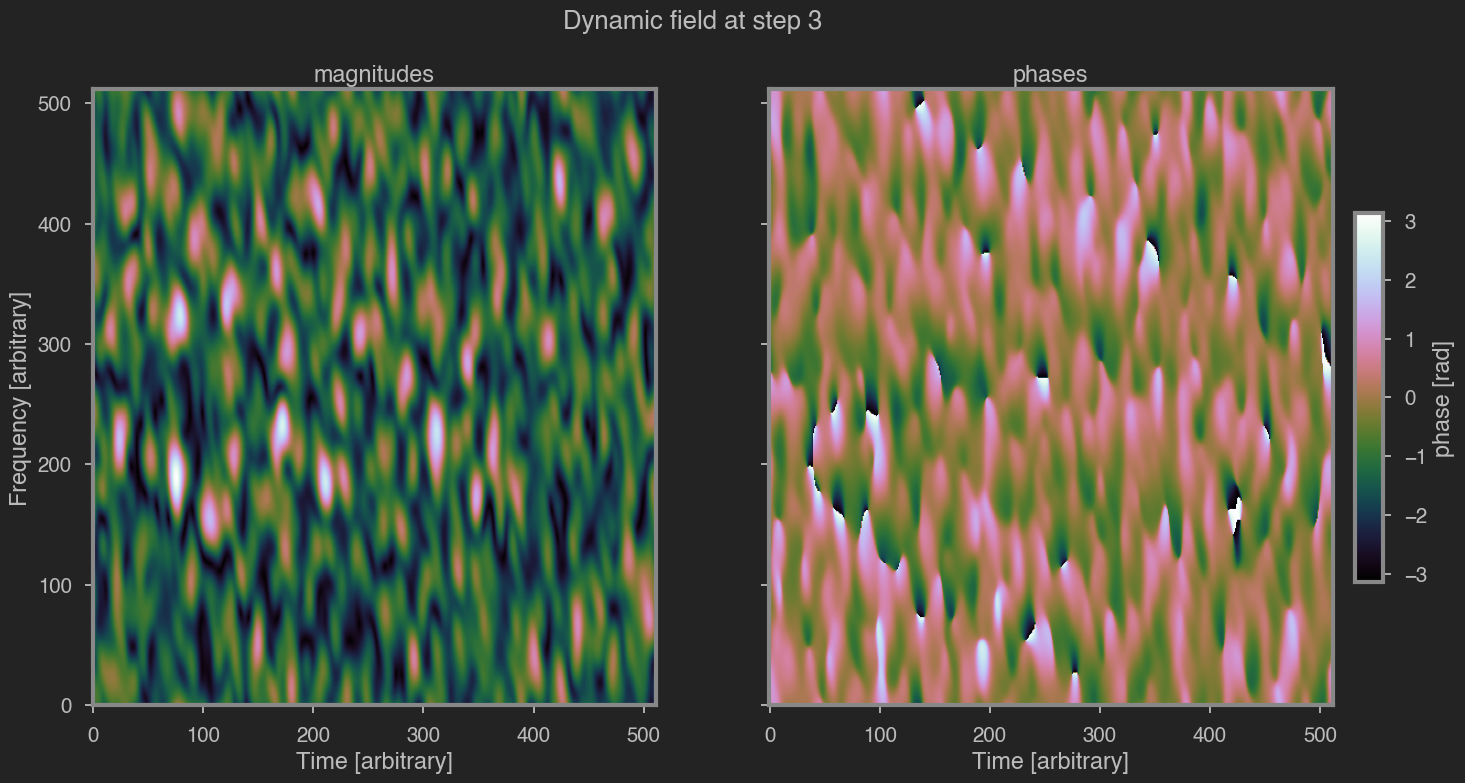

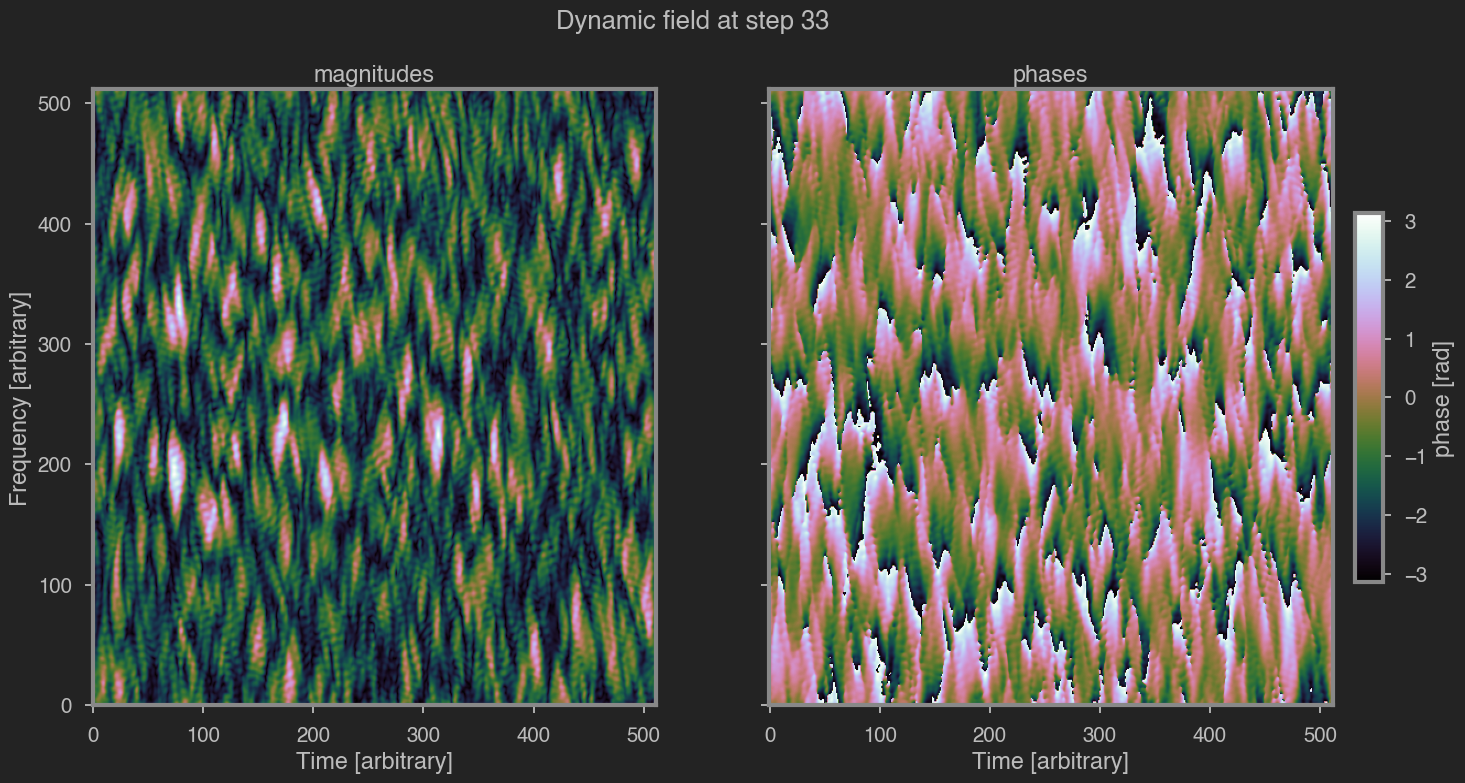

In [7]:
inspect_steps = [1, 2, 3]

if chosen_step > 0:
    inspect_steps.append(chosen_step)
else:
    inspect_steps.append(np.max(list(io["models"].keys())))

for _step in inspect_steps:
    get_dynamic_field_plot(data, io, _step)

### Diagnostic plot

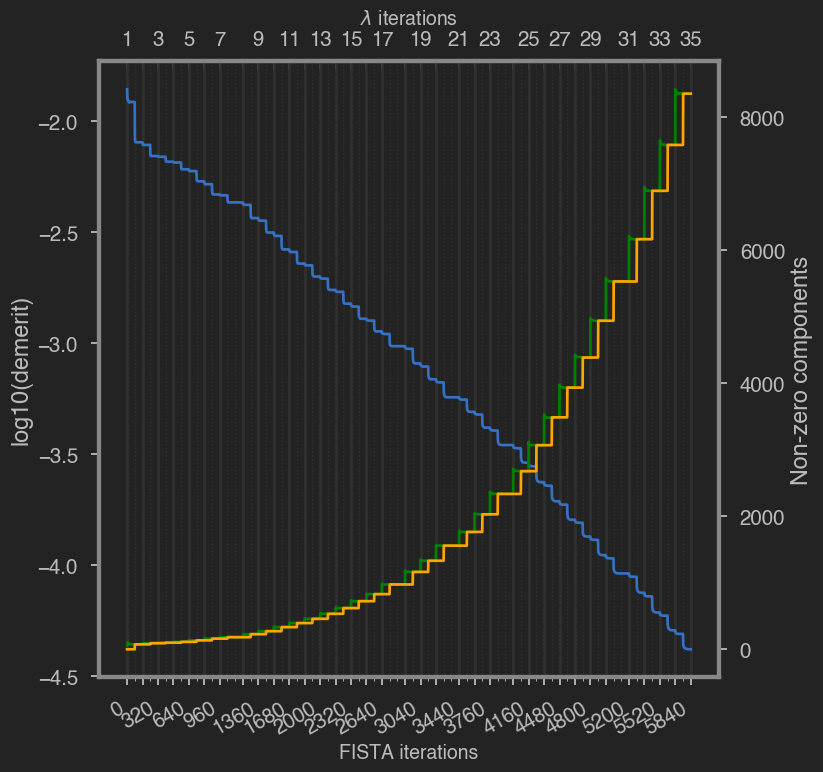

In [8]:
diagnostic_args = {}
if chosen_step > 0:
    diagnostic_args["max_step"] = chosen_step + 1
get_diag_plot(io, **diagnostic_args)

/Users/sosl/work/Manly/HFISTA/plotting.py:379: RuntimeWarning: divide by zero encountered in log10
  wf_log10_abs = np.log10(np.power(np.abs(fftshift(wavefield)), 2))


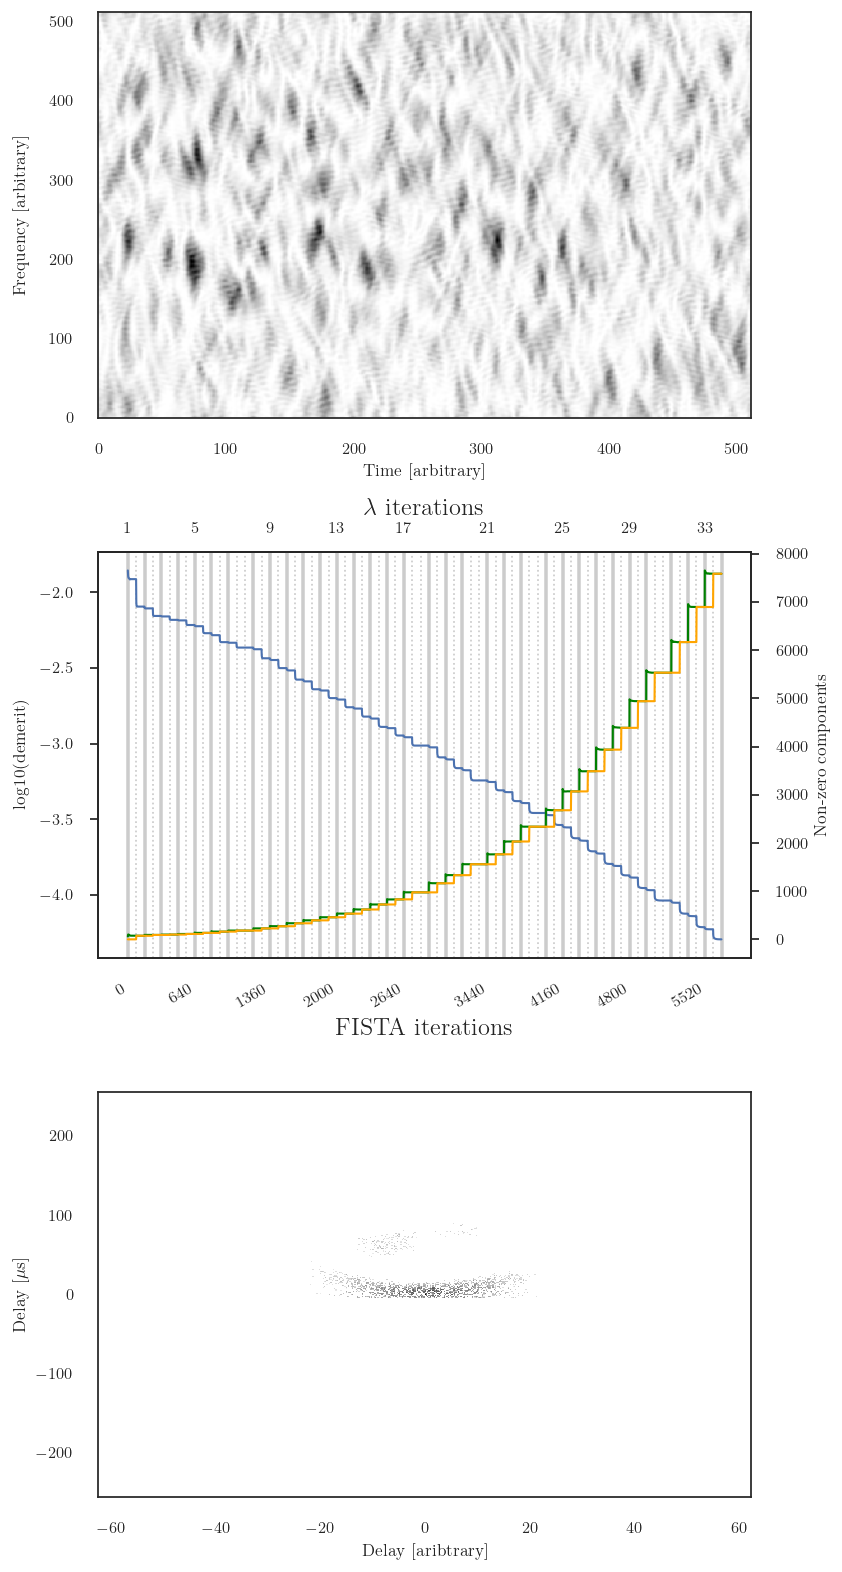

In [9]:
fig, axs = get_paper_figure(
    io,
    data,
    chosen_step=20,
    max_diagnostic_step=33,
    outfn="fig_25_noise_free.eps",
    tick_step=4,
    dense=False,
    vmin_data=0,
)

In [10]:
import pickle

with open("output/simulated_25_NF_io.pkl", "wb") as fh:
    pickle.dump(io, fh)